In [39]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [40]:
def display_scrollable_df(df, max_rows=5, height=300):
    display(HTML(df.head(max_rows).to_html(max_rows=max_rows, max_cols=100, escape=False)))
    display(HTML(f"""<style>
        .output_scroll {{
            max-height: {height}px;
            overflow-y: auto;
        }}
    </style>"""))

In [41]:
# Load Dataset - World Stock Prices (Daily Updating)
world_path = r"C:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\World Stock Prices (Daily Updating)\World-Stock-Prices-Dataset.csv"

world_df = pd.read_csv(world_path)

print("World Stock Prices Dataset:")
display_scrollable_df(world_df)

World Stock Prices Dataset:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-05-30 00:00:00-04:00,7.020000,7.240000,6.920000,7.100000,12750600.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-05-30 00:00:00-04:00,102.639999,102.940002,100.790001,102.000000,1505500.0,0.0,0.0,crocs,CROX,footwear,usa,NaN
2,2025-05-30 00:00:00-04:00,71.610001,72.470001,71.610001,72.099998,28013500.0,0.0,0.0,the coca-cola company,KO,food & beverage,usa,NaN
3,2025-05-30 00:00:00-04:00,125.080002,126.190002,123.750000,124.510002,82500.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
4,2025-05-30 00:00:00-04:00,294.970001,295.750000,291.630005,294.049988,5251700.0,0.0,0.0,american express,AXP,finance,usa,NaN


In [42]:
# Display basic information about the dataset
world_df.info()

# Display missing values per column
print("Missing values per column:")
print(world_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308386 entries, 0 to 308385
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           308386 non-null  object 
 1   Open           308386 non-null  float64
 2   High           308386 non-null  float64
 3   Low            308386 non-null  float64
 4   Close          308386 non-null  float64
 5   Volume         308386 non-null  float64
 6   Dividends      308386 non-null  float64
 7   Stock Splits   308386 non-null  float64
 8   Brand_Name     308386 non-null  object 
 9   Ticker         308386 non-null  object 
 10  Industry_Tag   308386 non-null  object 
 11  Country        308386 non-null  object 
 12  Capital Gains  2 non-null       float64
dtypes: float64(8), object(5)
memory usage: 30.6+ MB
Missing values per column:
Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume        

In [43]:
# Convert 'Date' column to datetime format and display the date range
world_df['Date'] = pd.to_datetime(world_df['Date'], utc=True)  
print("Date range:", world_df['Date'].min(), "to", world_df['Date'].max())

Date range: 2000-01-03 05:00:00+00:00 to 2025-05-30 04:00:00+00:00


In [44]:
# Display the types of each column
print("Column types:")
print(world_df.dtypes)

Column types:
Date             datetime64[ns, UTC]
Open                         float64
High                         float64
Low                          float64
Close                        float64
Volume                       float64
Dividends                    float64
Stock Splits                 float64
Brand_Name                    object
Ticker                        object
Industry_Tag                  object
Country                       object
Capital Gains                float64
dtype: object


In [45]:
# Filter the dataset for USA stocks and drop unnecessary columns
df_filtered = world_df.copy()
df_filtered = df_filtered[df_filtered["Country"] == "usa"]
df_filtered = df_filtered.drop(['Brand_Name', 'Capital Gains', 'Country', 'Industry_Tag', 'Stock Splits', 'Dividends'], axis=1)
df_filtered.head()

,Date,Open,High,Low,Close,Volume,Ticker
0,2025-05-30 04:00:00+00:00,7.020000,7.240000,6.920000,7.100000,12750600.0,PTON
1,2025-05-30 04:00:00+00:00,102.639999,102.940002,100.790001,102.000000,1505500.0,CROX
2,2025-05-30 04:00:00+00:00,71.610001,72.470001,71.610001,72.099998,28013500.0,KO
4,2025-05-30 04:00:00+00:00,294.970001,295.750000,291.630005,294.049988,5251700.0,AXP
6,2025-05-30 04:00:00+00:00,361.350006,367.040009,361.350006,365.190002,8726000.0,V


In [46]:
# Set 'Date' as the index for the filtered DataFrame
df_filtered.set_index('Date', inplace=True)
df_filtered.head()

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2025-05-30 04:00:00+00:00,7.020000,7.240000,6.920000,7.100000,12750600.0,PTON
2025-05-30 04:00:00+00:00,102.639999,102.940002,100.790001,102.000000,1505500.0,CROX
2025-05-30 04:00:00+00:00,71.610001,72.470001,71.610001,72.099998,28013500.0,KO
2025-05-30 04:00:00+00:00,294.970001,295.750000,291.630005,294.049988,5251700.0,AXP
2025-05-30 04:00:00+00:00,361.350006,367.040009,361.350006,365.190002,8726000.0,V


In [47]:
# Display missing values in the filtered DataFrame
df_filtered.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Ticker    0
dtype: int64

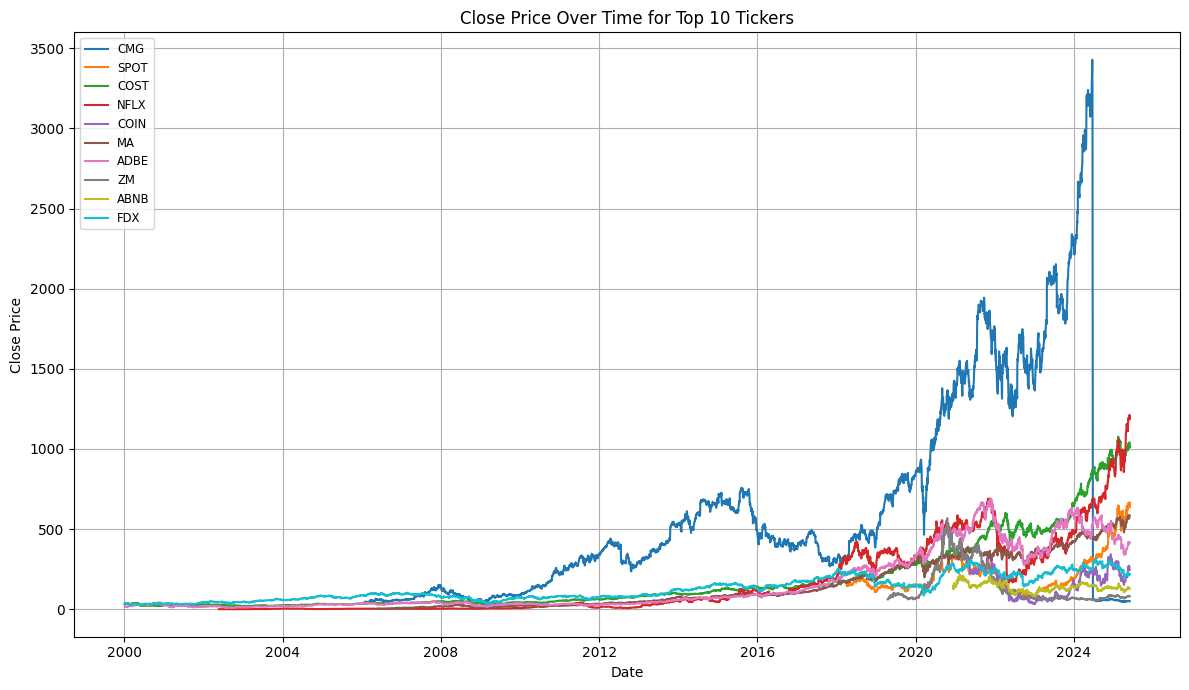

In [48]:
# Plotting the Close Price Over Time for the Top 10 Tickers
top_tickers = (
    df_filtered.groupby("Ticker")["Close"]
    .mean()
    .nlargest(10)
    .index
)

plt.figure(figsize=(12, 7))
for ticker in top_tickers:
    df_ticker = df_filtered[df_filtered["Ticker"] == ticker]
    plt.plot(df_ticker.index, df_ticker["Close"], label=ticker)

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price Over Time for Top 10 Tickers")
plt.legend(loc="upper left", fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# Filter the DataFrame for Netflix (Ticker: NFLX) and sort by date
df_stock = df_filtered[df_filtered["Ticker"] == "NFLX"].copy()
df_stock = df_stock.sort_index()
df_stock.head()

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2002-05-23 04:00:00+00:00,1.156429,1.242857,1.145714,1.196429,104790000.0,NFLX
2002-05-24 04:00:00+00:00,1.214286,1.225000,1.197143,1.210000,11104800.0,NFLX
2002-05-28 04:00:00+00:00,1.213571,1.232143,1.157143,1.157143,6609400.0,NFLX
2002-05-29 04:00:00+00:00,1.164286,1.164286,1.085714,1.103571,6757800.0,NFLX
2002-05-30 04:00:00+00:00,1.107857,1.107857,1.071429,1.071429,10154200.0,NFLX


# ARIMA

In [50]:
 # Use only the 'Close' column for ARIMA (a univariate time series model)
series = df_stock['Close']
series.head()

Date
2002-05-23 04:00:00+00:00    1.196429
2002-05-24 04:00:00+00:00    1.210000
2002-05-28 04:00:00+00:00    1.157143
2002-05-29 04:00:00+00:00    1.103571
2002-05-30 04:00:00+00:00    1.071429
Name: Close, dtype: float64

In [51]:
# ARIMA requires the series to be stationary, so perform the Augmented Dickey-Fuller test
result = adfuller(series.dropna()) 
print("Augmented Dickey-Fuller Test:")
print(f"ADF Statistic: {result[0]}") 
print(f"p-value: {result[1]}") 
if result[1] < 0.05:
    print("The series is stationary (reject null hypothesis).")
else:
    print("The series is non-stationary (fail to reject null hypothesis).")

Augmented Dickey-Fuller Test:
ADF Statistic: 2.660314559855617
p-value: 0.9990838905130095
The series is non-stationary (fail to reject null hypothesis).


In [52]:
# Transform the series to make it stationary
series_diff = series.diff().dropna() 

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(series_diff)
print("Augmented Dickey-Fuller Test on Differenced Series:")
print(f"ADF Statistic: {result_diff[0]}")
print(f"p-value: {result_diff[1]}")
if result_diff[1] < 0.05:
    print("The differenced series is stationary (reject null hypothesis).")
else:
    print("The differenced series is non-stationary (fail to reject null hypothesis).")
    

Augmented Dickey-Fuller Test on Differenced Series:
ADF Statistic: -10.970596731458945
p-value: 7.898561975334075e-20
The differenced series is stationary (reject null hypothesis).


In [53]:
# Convert the index to a PeriodIndex for daily frequency
series.index = pd.DatetimeIndex(series.index).to_period("D")

# Fit the ARIMA model on differenced series (d=1)
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()

# Print the summary of the ARIMA model
print(model_fit.summary())

C:\Users\anitr\AppData\Local\Temp\ipykernel_20796\4058731300.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  series.index = pd.DatetimeIndex(series.index).to_period("D")


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5842
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -19581.728
Date:                Sat, 21 Jun 2025   AIC                          39175.456
Time:                        01:05:46   BIC                          39215.492
Sample:                    05-23-2002   HQIC                         39189.378
                         - 05-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0096      0.007     -1.473      0.141      -0.022       0.003
ar.L2          0.0149      0.007      2.149      0.032       0.001       0.029
ar.L3          0.0053      0.006      0.864      0.3

In [54]:
# Forecast the next-day close price
forecast = model_fit.forecast(steps=1)
print("Next-day forecast for NFLX Close Price:")
print(forecast)

Next-day forecast for NFLX Close Price:
2018-05-21    1206.991989
Freq: D, dtype: float64


7-Day Forecast for NFLX Close Price:
2018-05-21    1206.991989
2018-05-22    1207.220684
2018-05-23    1207.012911
2018-05-24    1207.261301
2018-05-25    1207.302562
2018-05-26    1207.307288
2018-05-27    1207.306918
Freq: D, Name: predicted_mean, dtype: float64


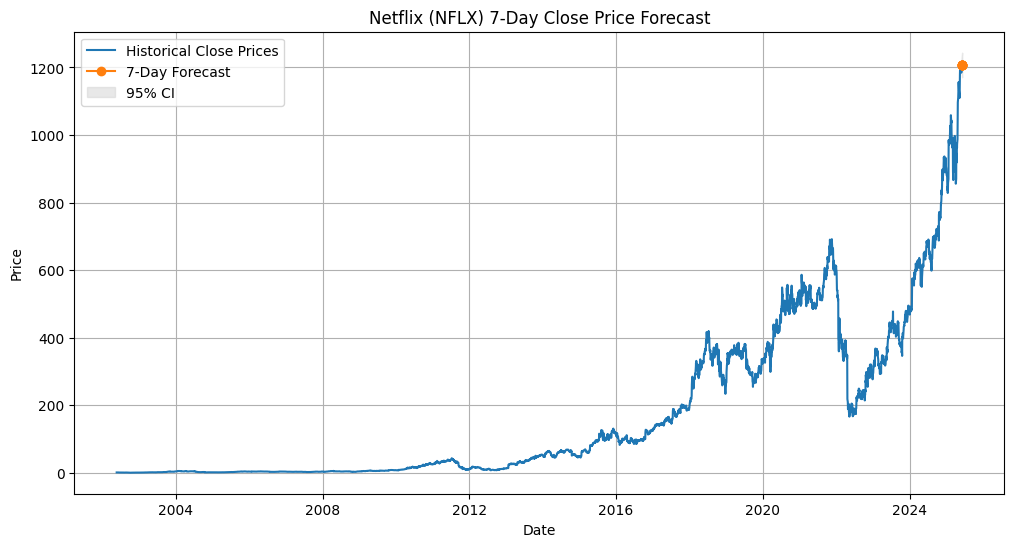

In [55]:
# Forecast the next 7 days
forecast_steps = 7
forecast = model_fit.get_forecast(steps=forecast_steps)
# Print the forecasted values
print("7-Day Forecast for NFLX Close Price:")
print(forecast.predicted_mean)

# Extract forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Convert forecast index back to datetime for plotting
last_date = series.index[-1].to_timestamp()
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot historical and forecasted values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(series.to_timestamp(), label='Historical Close Prices')
plt.plot(forecast_index, forecast_mean, label='7-Day Forecast', marker='o')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgray', alpha=0.5, label='95% CI')
plt.title("Netflix (NFLX) 7-Day Close Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()



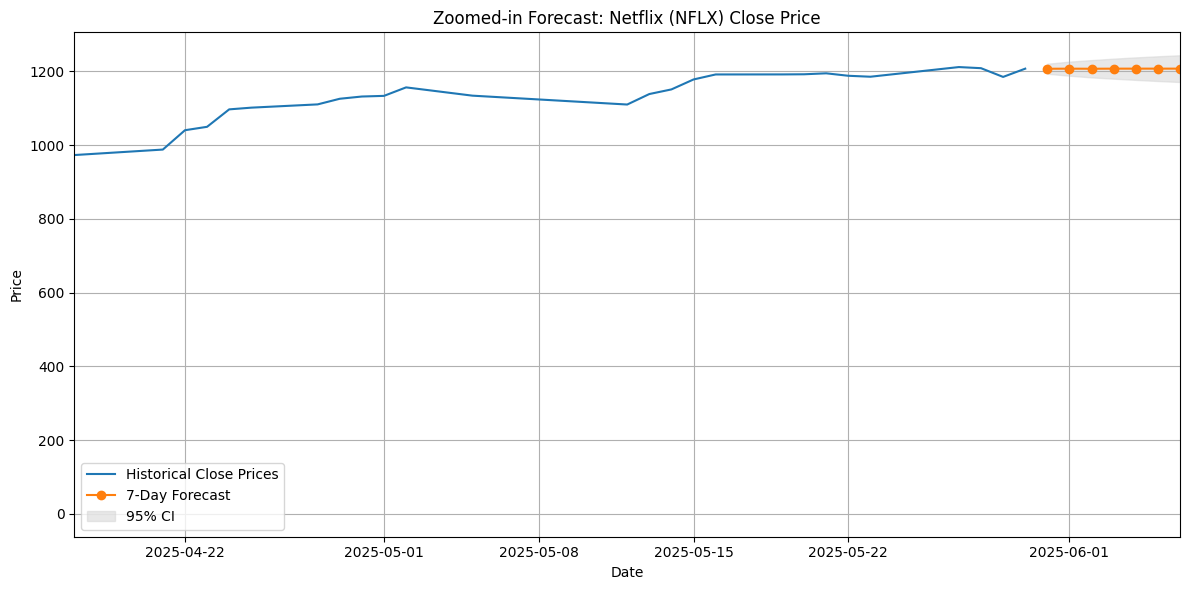

In [56]:
# Define how many days of historical data to show before the forecast
lookback_days = 30
start_zoom = series.index[-lookback_days].to_timestamp()
end_zoom = forecast_index[-1]

plt.figure(figsize=(12, 6))
plt.plot(series.to_timestamp(), label='Historical Close Prices')
plt.plot(forecast_index, forecast_mean, label='7-Day Forecast', marker='o')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgray', alpha=0.5, label='95% CI')

# Zoom into the last 'lookback_days' + forecast period
plt.xlim([start_zoom, end_zoom])

plt.title("Zoomed-in Forecast: Netflix (NFLX) Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Close': forecast_mean.values,
    'Lower_CI': conf_int.iloc[:, 0].values,
    'Upper_CI': conf_int.iloc[:, 1].values
})
forecast_df.set_index('Date', inplace=True)
forecast_df



,Forecasted_Close,Lower_CI,Upper_CI
Date,,,
2025-05-31,1206.991989,1193.441152,1220.542825
2025-06-01,1207.220684,1188.148535,1226.292832
2025-06-02,1207.012911,1183.574139,1230.451683
2025-06-03,1207.261301,1180.116353,1234.406248
2025-06-04,1207.302562,1176.818032,1237.787093
2025-06-05,1207.307288,1173.802869,1240.811707
2025-06-06,1207.306918,1171.031167,1243.582669


In [58]:
# Split into train/test (last 30 days for testing)
train = series[:-30]
test = series[-30:]

# Fit ARIMA on training data
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)

# Compare forecast vs actual
forecast = forecast.to_numpy()
actual = test.to_numpy()

In [59]:
# Calculate MAE and RMSE
mae = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mean_squared_error(actual, forecast))

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE:  167.49
RMSE: 178.54


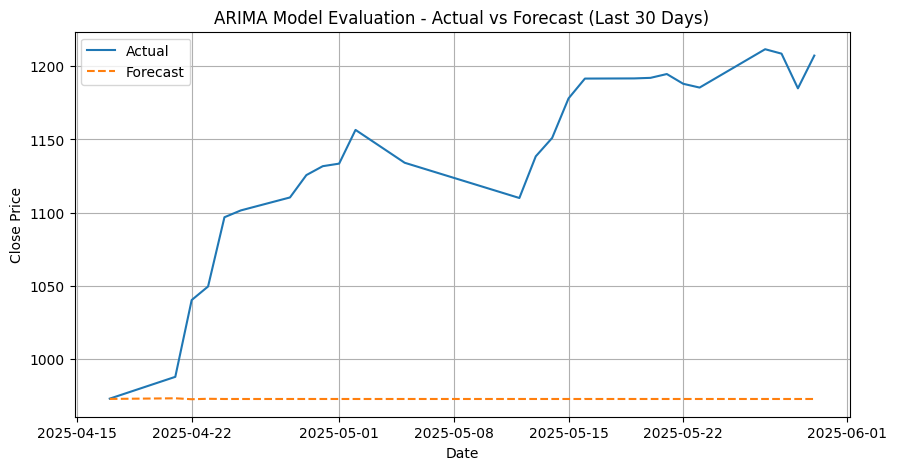

In [60]:
# Plot the actual vs forecasted values for the last 30 days
plt.figure(figsize=(10, 5))
plt.plot(test.index.to_timestamp(), actual, label='Actual')
plt.plot(test.index.to_timestamp(), forecast, label='Forecast', linestyle='--')
plt.title("ARIMA Model Evaluation - Actual vs Forecast (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

Performing stepwise search to minimize aic


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI5

 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=43263.068, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=41491.432, Time=0.10 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=43261.069, Time=0.04 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=40811.431, Time=0.20 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=40419.520, Time=0.27 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=40195.974, Time=0.57 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=40075.205, Time=0.88 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.14 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.14 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,0)(0,0,0)[0]             : AIC=40073.206, Time=0.34 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(0,0,0)[0]             : AIC=40193.974, Time=0.23 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.28 sec


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.00 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 14.489 seconds


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


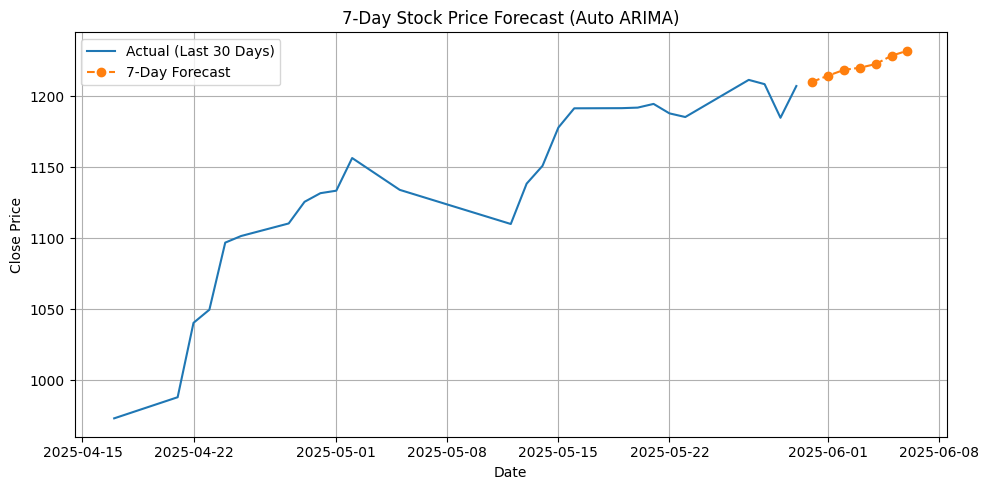

In [61]:
# Ensure 'Close' series has a datetime index
series = df_stock['Close']
series.index = series.index.to_timestamp()

# Fit the auto_arima model
model_auto = auto_arima(
    series,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Forecast the next 7 days
forecast_7d = model_auto.predict(n_periods=7)

# Create forecast dates
last_date = series.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)

# Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(series[-30:], label='Actual (Last 30 Days)')
plt.plot(forecast_dates, forecast_7d, label='7-Day Forecast', linestyle='--', marker='o')
plt.title('7-Day Stock Price Forecast (Auto ARIMA)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [65]:
# Evaluation of the auto_arima model

# Simulate a 30 day backtest by splitting the series into train and test sets
train = series[:-30]
test = series[-30:]

# Refit auto_arima on training data
model_backtest = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
forecast_test = model_backtest.predict(n_periods=30)

# Evaluate accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f"Backtest MAE:  {mae:.2f}")
print(f"Backtest RMSE: {rmse:.2f}")


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anitr\AAI510_Group6Project\AAI5

Backtest MAE:  36.53
Backtest RMSE: 43.47


c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\arima-env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


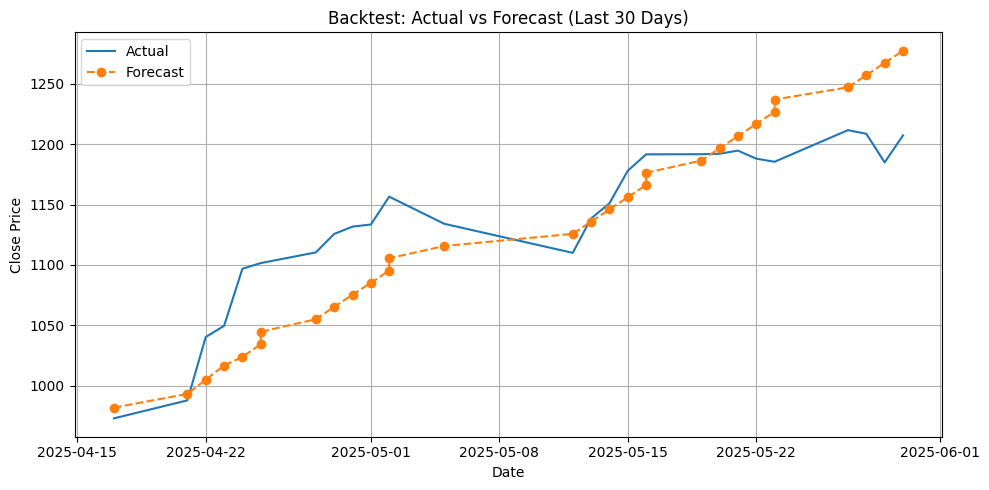

In [66]:
# Plot the backtest results
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast_test, label="Forecast", linestyle='--', marker='o')
plt.title("Backtest: Actual vs Forecast (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()